This notebook gives a explores, on a small scale, the Sherrington-Kirkpatrick model in a qualitative fashion. This is a model that shares many qualitative properties with the systems I have done my research on. It is defined by the Hamiltonian $H(\sigma)=\sum_{i,j}^n J_{ij} \sigma_i \sigma_j$, where $\sigma_i$ can take the values -1 or 1. For a given configuration of the $n$ $\sigma_i$'s, $\sigma$ we term $H(\sigma)$ the "energy" of the system.  Generally, at low temperatures, the combinations of the $\sigma_i$'s that we'll actually see are the ones that minimize the Hamiltonian $H$.

$J_{ij}$ is a $n \times n$ matrix that takes on random values - below we'll draw it from a normal distribution. We're going to look at some pretty small systems - real systems will be on the order of $n=10^{25}$ or so, but we'll be able to see some of the qualitative properties from these small sample sizes.

Because we're looking at a really small system, it will be reasonable to look at every single possible configuration of the $\sigma_i$'s.

In [1]:
addprocs(CPU_CORES)

4-element Array{Any,1}:
 2
 3
 4
 5

In [2]:

@everywhere const n=20
@everywhere const sdJ=1/sqrt(n)
@everywhere const meanJ=0


In [3]:
trials=600

600

We'll keep track of our $\sigma$ states by looking at the integer index in binary. 1 -> 1, 0 ->-1

In [4]:
@everywhere function bitarray(int::Int)  
    2*digits(int,2,n)-1
end

In [5]:
@everywhere function energy(index, J)
    c=bitarray(index)
    -sum(J.*reshape(kron(c,c),(n,n)))
end

The distance function defines a distance between states, given by how 
many flips (ie changing a single $\sigma$ from +1 to -1) it takes to get from one state to the other. Since a given state and that state with 
all sigmas flipped are equivilent, we have to check the 
distance between both equivilent states. Since we indexed our states by the
binary representation, the xor operator can do the work of finding the distance
for us

In [6]:

@everywhere function distance(a::Int,b::Int)     
    min(sum(digits(a$b,2,n)),sum(digits((2^(n+1)-1-a)$b,2,n)))
end

We're just going to focus on the two states with the lowest $H$, and look at the difference in $H$ between them (the "energy gap") and the number of flips (the "distance") between them.

In [7]:
@everywhere function energydifferance(energies)   
    lowenergy=findmin(energies)
    energies[lowenergy[2]]=NaN
    secondlow=findmin(energies)
    [lowenergy[1]-secondlow[1],distance(lowenergy[2]-1,secondlow[2]-1)]
end
@everywhere function energyinstance(J)
    energydifferance([energy(i,J) for i=0:2^(n-1)-1])
end

In [8]:
gapdistance=@parallel (vcat) for i=1:trials
    transpose(energyinstance(randn(n,n)*sdJ+meanJ))
end


600x2 Array{Float64,2}:
 -0.286696    2.0
 -0.161078    3.0
 -2.56616e-5  1.0
 -0.0410452   1.0
 -0.908803    1.0
 -0.72387     3.0
 -0.936099    2.0
 -1.55849     1.0
 -0.426691    1.0
 -0.753138    6.0
 -0.167309    2.0
 -0.0439393   3.0
 -0.847758    1.0
  ⋮              
 -0.136112    1.0
 -0.261946    1.0
 -0.0640069   7.0
 -0.919173    2.0
 -0.5787      1.0
 -0.716954    1.0
 -0.249825    1.0
 -0.264218    1.0
 -0.550561    1.0
 -0.473101    1.0
 -0.176208    9.0
 -0.743938    4.0

In [9]:
rmprocs(workers())

:ok

In [10]:
using PyPlot

INFO: Loading help data...


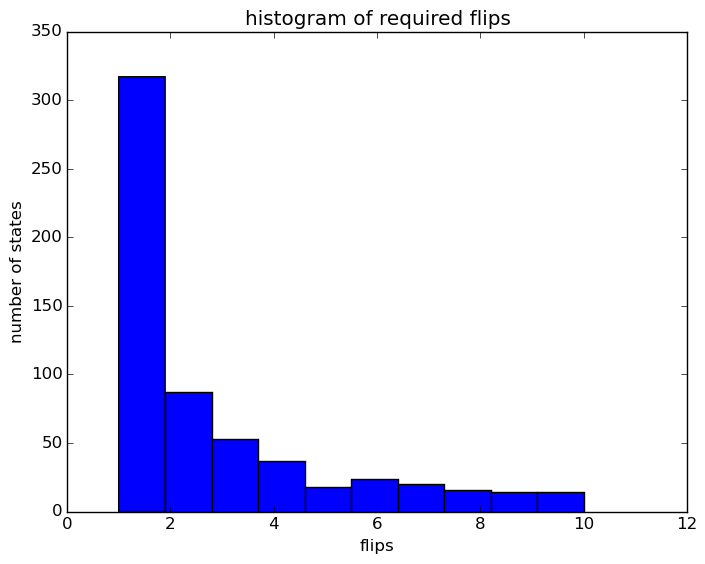

In [11]:
PyPlot.plt.hist(gapdistance[:,2],ceil(n/2))
title("histogram of required flips ")
ylabel("number of states")
xlabel("flips")
show()

We can see that, while about 50% of the two neiboring lowest states are just one flip away from eachother, quite a few of them are a lot farther, some even take the maximum possible number of flips.

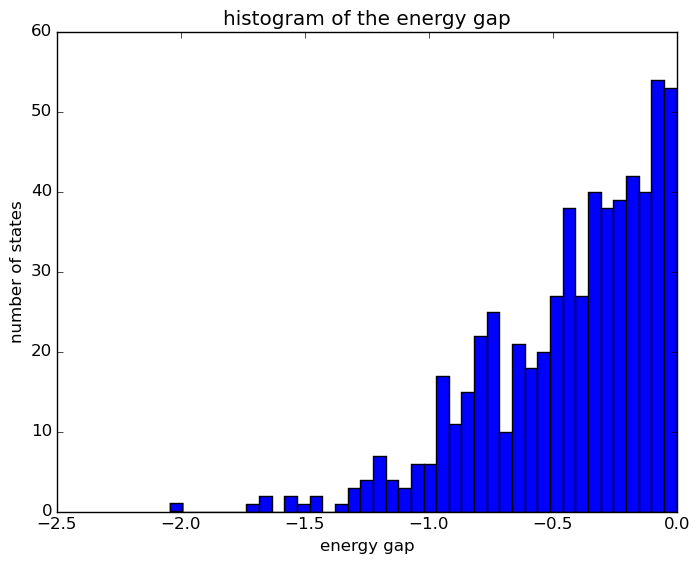

In [15]:
PyPlot.plt.hist(gapdistance[:,1],40)
title("histogram of the energy gap ")
ylabel("number of states")
xlabel("energy gap")
show()

The distribution of the energy gap is clustered around zero, and as we see below, some of them are the states that are very far from each other.  Even for this very small sample, we see that there are low energy states that are at nearly the same energy, yet it will take a significant change in the system configuration to lower that energy the small amount.

For most physical systems, finding the low temperature behavior comes down to finding the global energy minimum. In this model, however, we see evidence of what is called "glassy" behavior: the system has many states clustered around a low energy, however these states may be very distinct from eachother, and become physically relevent.  Thus, the local minima become equally important to the global one.

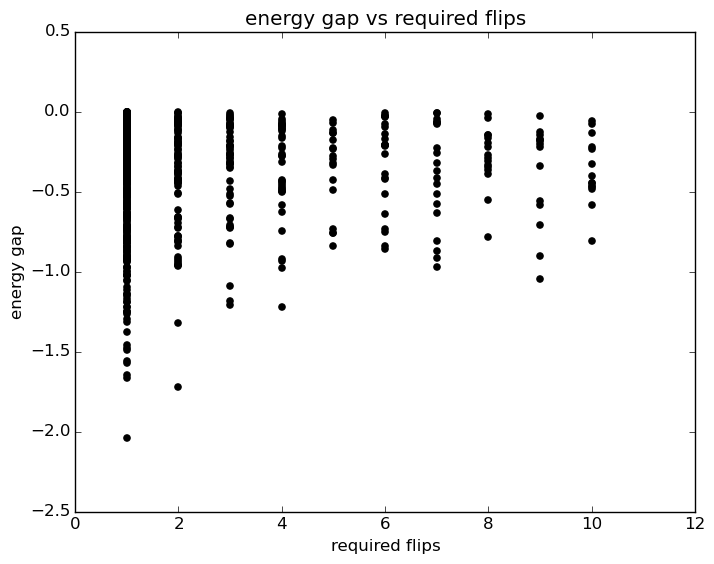

In [14]:
scatter(gapdistance[:,2],gapdistance[:,1],color="black")
title("energy gap vs required flips")
xlabel("required flips")
ylabel("energy gap")
show()

In [8]:
averagelist= @parallel (vcat) for i=1:ceil(n/2)
    mean(getindex(gapdistance[:,1],find((x)->x==i,gapdistance[:,2])))
end

5-element Array{Float64,1}:
 -0.217891 
 -0.205863 
 -0.23322  
 -0.0497111
 -0.200471 

In [9]:
using DataFrames
using GLM

In [32]:
averageDF=DataFrame(energygap=averagelist,flips=1:ceil(n/2))
gaplinearmodel=glm(energygap ~ flips, averageDF, Normal(),IdentityLink())

,energygap,flips
1,-0.2178914044152098,1.0
2,-0.20586267810226475,2.0
3,-0.2332198315326476,3.0
4,-0.04971110588082883,4.0
5,-0.20047130147747713,5.0


In [57]:
function rsquared(data,prediction)
    1-(sum((data-prediction).^2))/(sum((data-mean(data)).^2))
end
rsquared(averagelist,predict(gaplinearmodel))

rsquared (generic function with 1 method)

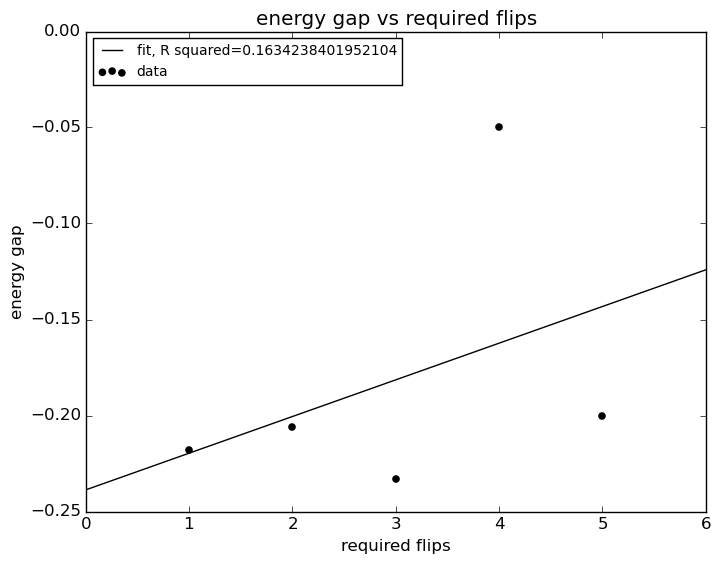

In [63]:
xdata=collect(0:ceil(n/2)+1)
plot(xdata,coef(gaplinearmodel)[2]*xdata+coef(gaplinearmodel)[1], color="black", label="fit, R squared=$(rsquared(averagelist,predict(gaplinearmodel)))")
xlim(0,ceil(n/2)+1)
scatter(1:ceil(n/2),averagelist,color="black",label="data")
title("energy gap vs required flips")
xlabel("required flips")
ylabel("energy gap")
legend(loc="upper left",fontsize=10)
show()

In [45]:
Pkg.add("MultivariateStats")

INFO: Cloning cache of MultivariateStats from git://github.com/JuliaStats/MultivariateStats.jl.git
INFO: Installing MultivariateStats v0.2.1
INFO: Package database updated
